In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import os.path as osp
import seaborn as sns
from tqdm import tqdm

from data_loader.feature_generator import FeatureGenerator
from model.pca import PCATransform
from data_loader.data_split import get_train_test_split, split_feature_and_labels
from model.random_forest import RandomForest
from utils.classification_stats import ClassificationStatistics

## Analyzing International Matches Data

In [3]:
# Importing the dataset
data_dir_path = '/Users/neelabh/Desktop/Work/Projects/CS 7641 ML/data'
source_dir = 'source'


In [4]:
match_results_df = pd.read_csv(osp.join(data_dir_path, source_dir, 'match_results.csv'))

In [5]:
match_results_df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [6]:
match_results_df.describe()

,home_score,away_score
count,45100.000000,45100.000000
mean,1.739601,1.177982
std,1.746247,1.392395
min,0.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,31.000000,21.000000


In [7]:
match_results_df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral'],
      dtype='object')

In [8]:
set(match_results_df['tournament'])

{'ABCS Tournament',
 'AFC Asian Cup',
 'AFC Asian Cup qualification',
 'AFC Challenge Cup',
 'AFC Challenge Cup qualification',
 'AFF Championship',
 'AFF Championship qualification',
 'African Cup of Nations',
 'African Cup of Nations qualification',
 'African Nations Championship',
 'African Nations Championship qualification',
 'Afro-Asian Games',
 'Amílcar Cabral Cup',
 'Arab Cup',
 'Arab Cup qualification',
 'Atlantic Cup',
 'Atlantic Heritage Cup',
 'Balkan Cup',
 'Baltic Cup',
 'Beijing International Friendship Tournament',
 'Bolivarian Games',
 'Brazil Independence Cup',
 'British Home Championship',
 'CAFA Nations Cup',
 'CCCF Championship',
 'CECAFA Cup',
 'CFU Caribbean Cup',
 'CFU Caribbean Cup qualification',
 'CONCACAF Championship',
 'CONCACAF Championship qualification',
 'CONCACAF Nations League',
 'CONCACAF Nations League qualification',
 'CONIFA Africa Football Cup',
 'CONIFA Asia Cup',
 'CONIFA European Football Cup',
 'CONIFA South America Football Cup',
 'CONIFA W

In [22]:
total_matches_per_team = pd.DataFrame(match_results_df['home_team'].value_counts() + match_results_df['away_team'].value_counts())
total_matches_per_team.reset_index(inplace=True)
total_matches_per_team.columns = ['team', 'total_matches']
total_matches_per_team.sort_values(by='total_matches', ascending=False, inplace=True)
total_matches_per_team.head()

,team,total_matches
264,Sweden,1063.0
84,England,1057.0
12,Argentina,1030.0
38,Brazil,1030.0
103,Germany,995.0


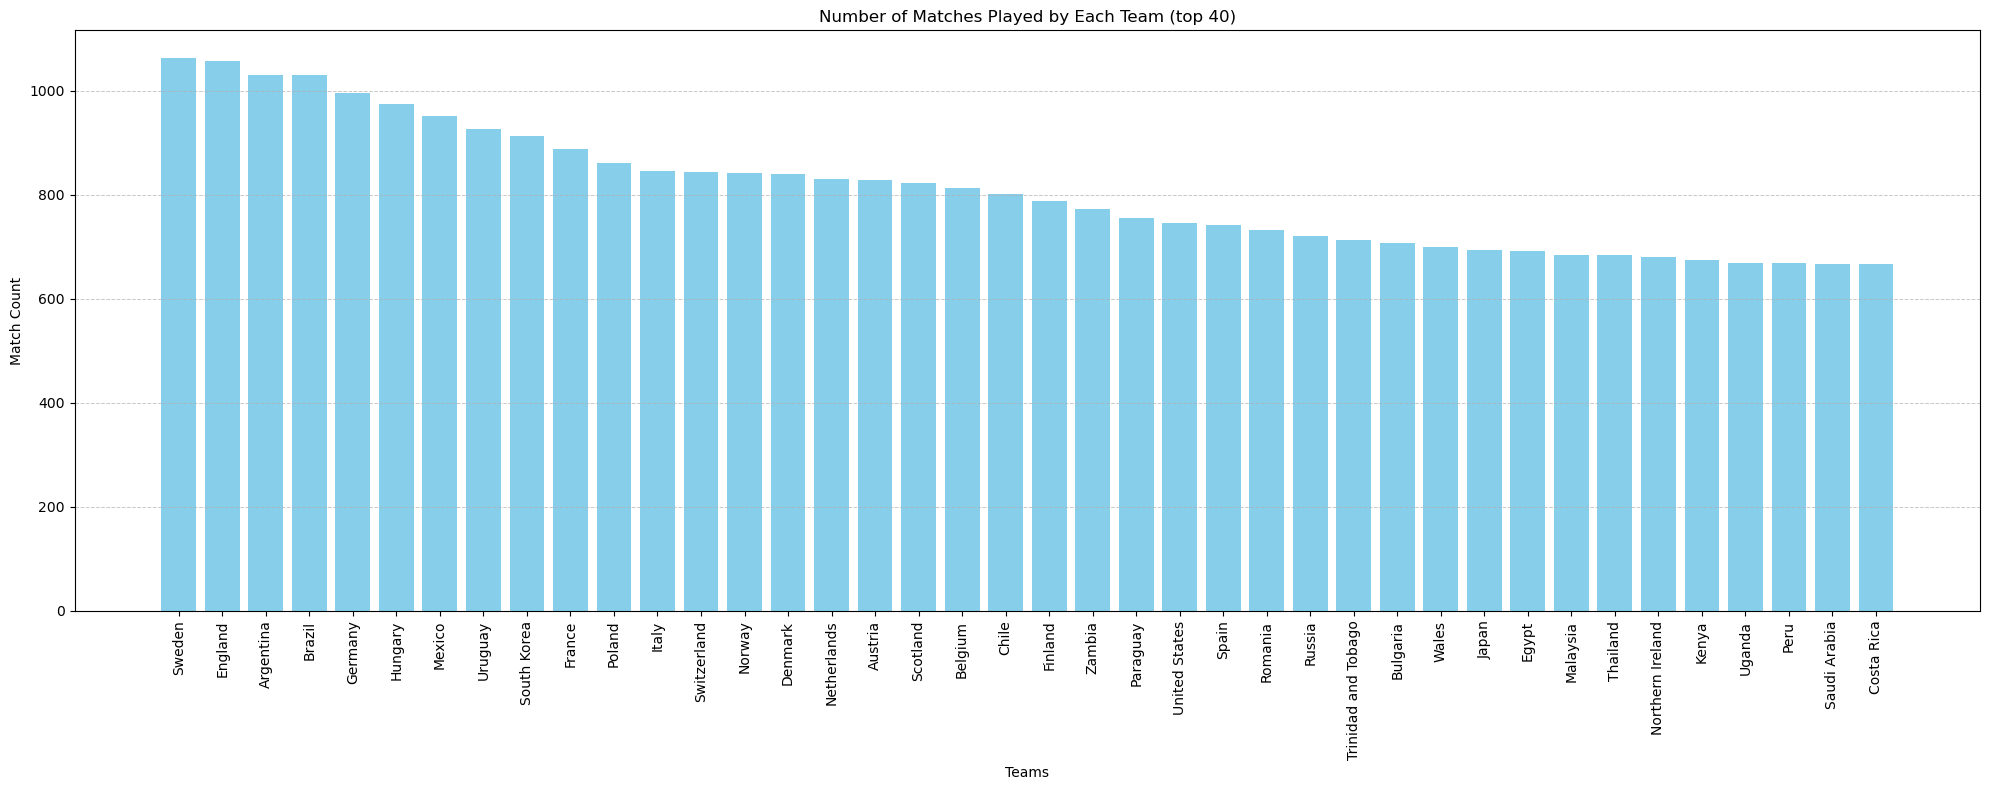

In [24]:
top_teams = 40
plt.figure(figsize=(20, 8))
plt.bar(total_matches_per_team['team'][:top_teams], total_matches_per_team['total_matches'][:top_teams], color='skyblue')
plt.xlabel('Teams')
plt.ylabel('Match Count')
plt.title('Number of Matches Played by Each Team (top 40)')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()

In [61]:
home_tournament_count = match_results_df.groupby(['home_team', 'tournament']).size().reset_index(name='home_matches')
away_tournament_count = match_results_df.groupby(['away_team', 'tournament']).size().reset_index(name='away_matches')
home_tournament_count.rename(columns={'home_team': 'team'}, inplace=True)
away_tournament_count.rename(columns={'away_team': 'team'}, inplace=True)

combined_tournament_count = pd.merge(home_tournament_count, away_tournament_count, how='outer', on=['team', 'tournament'])

combined_tournament_count = combined_tournament_count.fillna(0)

combined_tournament_count['total_matches'] = combined_tournament_count['home_matches'] + combined_tournament_count['away_matches']

tournament_match_counts = combined_tournament_count.pivot_table(index='team', columns='tournament', values='total_matches', fill_value=0)
tournament_match_counts.reset_index(inplace=True)
tournament_match_counts['total_matches'] = tournament_match_counts.select_dtypes(include=[np.number]).sum(axis=1)

tournament_match_counts.sort_values(by='total_matches', ascending=False, inplace=True)

tournament_match_counts


tournament,team,ABCS Tournament,AFC Asian Cup,AFC Asian Cup qualification,AFC Challenge Cup,AFC Challenge Cup qualification,AFF Championship,AFF Championship qualification,African Cup of Nations,African Cup of Nations qualification,...,United Arab Emirates Friendship Tournament,VFF Cup,Vietnam Independence Cup,Viva World Cup,WAFF Championship,West African Cup,Windward Islands Tournament,World Unity Cup,Évence Coppée Trophy,total_matches
264,Sweden,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1063
84,England,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1057
38,Brazil,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1030
12,Argentina,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1030
103,Germany,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,Palau,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
277,Ticino,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
263,Surrey,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
160,Madrid,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


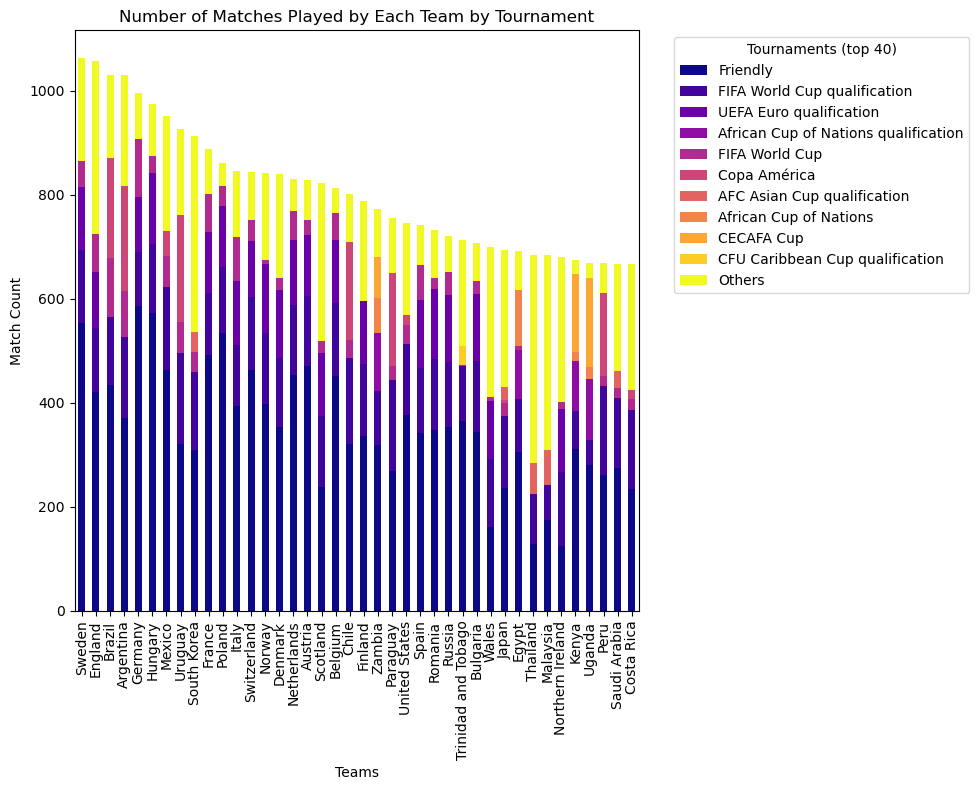

In [62]:
import matplotlib.pyplot as plt

# Assuming tournament_match_counts is the DataFrame with tournaments as columns and teams as rows

# Calculate sums for each tournament across all teams
tournament_match_counts.set_index('team', inplace=True)
tournament_sums = tournament_match_counts.select_dtypes(include=[np.number]).drop(columns=['total_matches']).sum().sort_values(ascending=False)

# Get the top 4 tournaments
top_tournaments = tournament_sums.iloc[:10].index.tolist()

# Now, create a new 'Others' column in the DataFrame
tournament_match_counts['Others'] = tournament_match_counts.select_dtypes(include=[np.number]).drop(columns=['total_matches']).apply(
    lambda row: sum(row[tournament] for tournament in row.index if tournament not in top_tournaments),
    axis=1
)

# Keep only the top 4 tournaments and the 'Others' column
columns_to_keep = top_tournaments + ['Others']
tournament_match_counts_top4 = tournament_match_counts[columns_to_keep]
# Now plot the stacked bar chart
colormap = plt.cm.plasma
tournament_match_counts_top4[:top_teams].plot(kind='bar', stacked=True, figsize=(10, 8), colormap=colormap)

# Labels and Title
plt.xlabel('Teams')
plt.ylabel('Match Count')
plt.title('Number of Matches Played by Each Team by Tournament')

# Rotate x-axis labels so they fit and are readable
plt.xticks(rotation=90)

# Legend
plt.legend(title='Tournaments (top 40)', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()  # Adjust the padding to make room for the rotated x-axis labels and the legend
plt.show()


## Analyzing FIFA Rankings Data

In [5]:
rankings_file = osp.join(data_dir_path, source_dir, 'rankings.csv')
rankings_df = pd.read_csv(rankings_file)

In [6]:
rankings_df.head()

,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date
0,1,Germany,GER,57.0,0.0,0,UEFA,1992-12-31
1,96,Syria,SYR,11.0,0.0,0,AFC,1992-12-31
2,97,Burkina Faso,BFA,11.0,0.0,0,CAF,1992-12-31
3,99,Latvia,LVA,10.0,0.0,0,UEFA,1992-12-31
4,100,Burundi,BDI,10.0,0.0,0,CAF,1992-12-31


In [72]:
rankings_df.columns

Index(['rank', 'country_full', 'country_abrv', 'total_points',
       'previous_points', 'rank_change', 'confederation', 'rank_date'],
      dtype='object')

## Feature Selection

In [85]:
individual_window_size = 5
h2h_window_size = 5
last_n_data = 5000

In [68]:
feature_generator = FeatureGenerator(individual_window_size, h2h_window_size)
features = feature_generator(match_results_df[-last_n_data:])
features.to_csv(osp.join(data_dir_path, 'features_last_' + str(last_n_data) + '_windows_' + str(individual_window_size) + '_' + str(h2h_window_size) + '.csv'), index=False)

## Feature Analysis

In [86]:
features = pd.read_csv(osp.join(data_dir_path, 'features_last_' + str(last_n_data) + '_windows_' + str(individual_window_size) + '_' + str(h2h_window_size) + '.csv'))

In [87]:
features.head()

,home_win_count,away_win_count,h2h_home_win_count,h2h_away_win_count,home_mean_goals_scored,home_mean_goals_conceded,home_std_goals_scored,home_std_goals_conceded,away_mean_goals_scored,away_mean_goals_conceded,...,away_rank_change,home_team_opposition_rank_diff,away_team_opposition_rank_diff,is_friendly,is_qualifier,is_tournament,home_match_for_home_team,home_team_win,draw,away_team_win
0,2.0,1.0,3.0,2.0,0.8,1.0,0.748331,0.632456,0.4,2.2,...,0.0,-54.6,-41.2,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,1.0,3.0,4.0,1.0,0.2,1.2,0.400000,0.979796,1.2,1.2,...,0.0,-3.8,8.6,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.0,3.0,2.0,0.0,0.0,1.0,0.000000,0.894427,1.6,0.6,...,0.0,77.4,-22.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3.0,0.0,0.0,0.0,0.8,1.8,1.600000,0.748331,1.8,0.8,...,1.0,-122.0,13.6,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2.0,2.0,0.0,3.0,0.0,1.8,0.000000,1.166190,1.0,2.4,...,0.0,3.4,-4.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


In [88]:
features.describe()

,home_win_count,away_win_count,h2h_home_win_count,h2h_away_win_count,home_mean_goals_scored,home_mean_goals_conceded,home_std_goals_scored,home_std_goals_conceded,away_mean_goals_scored,away_mean_goals_conceded,...,away_rank_change,home_team_opposition_rank_diff,away_team_opposition_rank_diff,is_friendly,is_qualifier,is_tournament,home_match_for_home_team,home_team_win,draw,away_team_win
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2.393400,2.359800,1.444200,1.245400,1.363957,1.321230,1.097325,1.047901,1.304573,1.385877,...,-0.060000,1.449280,-1.78352,0.298200,0.701800,0.332200,0.702800,0.482800,0.289000,0.228200
std,1.095297,1.088201,1.424813,1.343853,0.815795,0.852682,0.653932,0.590101,0.795830,0.920850,...,2.320491,49.286168,50.31410,0.457514,0.457514,0.471049,0.457071,0.499754,0.453343,0.419714
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-25.000000,-165.800000,-206.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,0.000000,0.000000,0.800000,0.800000,0.748331,0.748331,0.800000,0.800000,...,0.000000,-27.000000,-31.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2.000000,1.000000,1.000000,1.200000,1.200000,0.979796,0.894427,1.200000,1.200000,...,0.000000,2.400000,0.00000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,3.000000,3.000000,2.000000,2.000000,1.800000,1.600000,1.356466,1.326650,1.800000,1.800000,...,0.000000,29.600000,25.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,5.000000,5.000000,5.000000,5.000000,6.800000,7.200000,6.196773,5.678028,6.000000,8.000000,...,14.000000,204.800000,205.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [89]:
correlation = features.corr()
correlation

,home_win_count,away_win_count,h2h_home_win_count,h2h_away_win_count,home_mean_goals_scored,home_mean_goals_conceded,home_std_goals_scored,home_std_goals_conceded,away_mean_goals_scored,away_mean_goals_conceded,...,away_rank_change,home_team_opposition_rank_diff,away_team_opposition_rank_diff,is_friendly,is_qualifier,is_tournament,home_match_for_home_team,home_team_win,draw,away_team_win
home_win_count,1.000000,0.072717,-0.016759,0.056441,0.103474,0.115778,0.105466,0.127445,0.054291,-0.012370,...,-0.022115,-0.011423,0.002609,-0.012199,0.012199,-0.021494,-0.009353,-0.007918,0.033251,-0.026487
away_win_count,0.072717,1.000000,-0.031108,0.058208,-0.025442,0.044315,0.002615,0.036865,0.122598,0.094841,...,-0.018067,-0.030136,0.012507,-0.003400,0.003400,-0.026001,-0.008984,-0.022643,0.036125,-0.012058
h2h_home_win_count,-0.016759,-0.031108,1.000000,-0.299216,0.209869,-0.225411,0.131004,-0.166428,-0.127077,0.104200,...,0.011148,0.237911,-0.141538,0.010955,-0.010955,-0.000839,0.056544,0.262307,-0.264747,-0.026370
h2h_away_win_count,0.056441,0.058208,-0.299216,1.000000,-0.133321,0.124750,-0.094411,0.071924,0.210018,-0.196899,...,0.001836,-0.149109,0.214229,-0.116768,0.116768,0.020980,0.042228,-0.269083,0.268065,0.030855
home_mean_goals_scored,0.103474,-0.025442,0.209869,-0.133321,1.000000,-0.346144,0.749662,-0.228755,0.162360,-0.049817,...,0.010059,0.400288,0.076430,-0.021175,0.021175,0.071473,0.005797,0.158610,-0.143507,-0.033851
home_mean_goals_conceded,0.115778,0.044315,-0.225411,0.124750,-0.346144,1.000000,-0.206353,0.738552,-0.034569,0.189882,...,0.010633,-0.392416,-0.076714,-0.059740,0.059740,0.000168,-0.012499,-0.171577,0.222947,-0.036513
home_std_goals_scored,0.105466,0.002615,0.131004,-0.094411,0.749662,-0.206353,1.000000,-0.109788,0.138460,-0.000993,...,0.012546,0.251446,0.042108,-0.018809,0.018809,0.037625,0.003250,0.118047,-0.090586,-0.042715
home_std_goals_conceded,0.127445,0.036865,-0.166428,0.071924,-0.228755,0.738552,-0.109788,1.000000,-0.015263,0.156506,...,0.022029,-0.276909,-0.066757,-0.045023,0.045023,0.009486,-0.008867,-0.118178,0.170971,-0.043955
away_mean_goals_scored,0.054291,0.122598,-0.127077,0.210018,0.162360,-0.034569,0.138460,-0.015263,1.000000,-0.334932,...,-0.100309,0.067329,0.376637,-0.053760,0.053760,0.052190,-0.030909,-0.153291,0.155576,0.014482
away_mean_goals_conceded,-0.012370,0.094841,0.104200,-0.196899,-0.049817,0.189882,-0.000993,0.156506,-0.334932,1.000000,...,0.113646,-0.096067,-0.350262,-0.029458,0.029458,0.010119,0.007761,0.179043,-0.125973,-0.077120


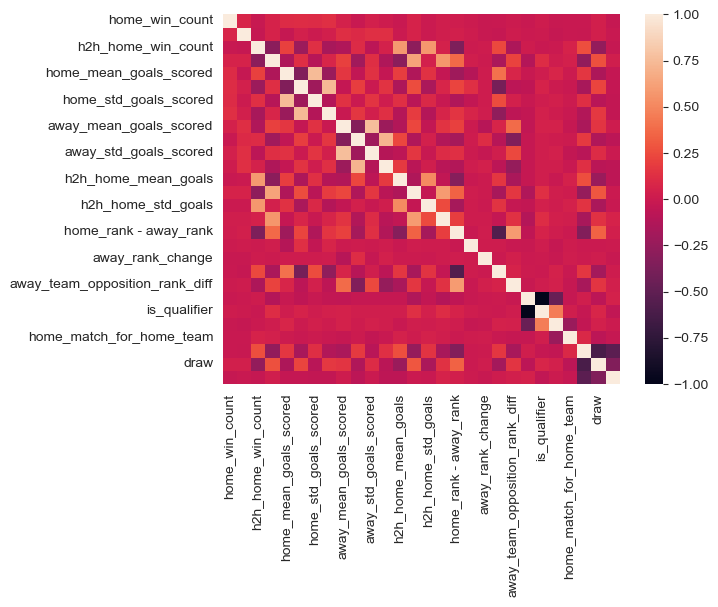

In [90]:
sns.heatmap(correlation)
plt.show()

## PCA

In [113]:
X_train, y_train = split_feature_and_labels(features)


In [114]:
pca_transform = PCATransform()
var_values = pca_transform.tune_n_components(X_train, 1, 20)


100%|██████████| 19/19 [00:00<00:00, 22.80it/s]


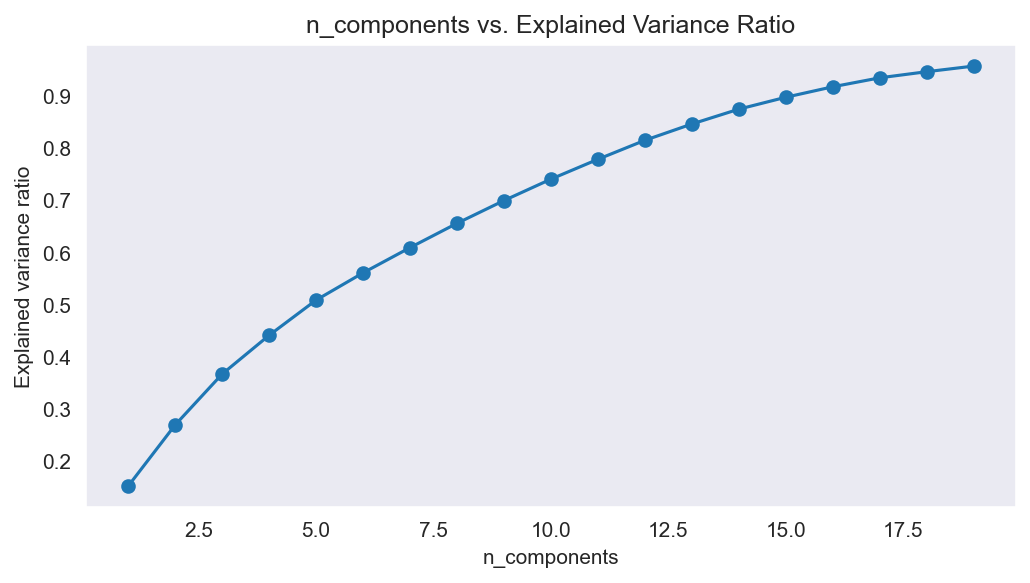

In [115]:
plt.figure(figsize=(8,4),dpi=150)
plt.grid()
plt.plot(var_values.keys(),var_values.values(),marker='o')
plt.xlabel('n_components')
plt.ylabel('Explained variance ratio')
plt.title('n_components vs. Explained Variance Ratio')
plt.show()

In [116]:
chosen_n_components = 5
pca = PCATransform(n_components=chosen_n_components)
pca.fit(X_train)
pca_X_train = pca.transform(X_train)

## Random Forest

In [117]:
use_pca = True

In [118]:
x_train, x_test, y_train, y_test = get_train_test_split(pca_X_train if use_pca else X_train, y_train)

In [119]:
y_train = y_train.iloc[:, :1].squeeze()
y_test = y_test.iloc[:, :1].squeeze()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(4000, 5) (4000,) (1000, 5) (1000,)


In [122]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [10, 20, 30, 40, 50, None]
# Minimum number of samples required to split a node
min_samples_split = [1, 4, 8, 12, 16, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(1,15, num=2)]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_forest = RandomForest()
best_params = random_forest.tune_hyperparameters_random_search(X = x_train, y = y_train, n_estimators = n_estimators, max_features = max_features, max_depth = max_depth, min_sample_split = min_samples_split, min_samples_leaf = min_samples_leaf, bootstrap = bootstrap, n_iter = 100, cv = 5, verbose=1, n_jobs = -1)
random_forest.initialize_model_hyperparameters(**best_params)
random_forest.fit(x_train, y_train)
accuracy = random_forest.score(x_test, y_test)
print('best_params: ', best_params)
print('Accuracy -', accuracy)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/neelabh/anaconda3/envs/gatechcs7641env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
75 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neelabh/anaconda3/envs/gatechcs7641env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neelabh/anaconda3/envs/gatechcs7641env/lib/python3.10/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/neelabh/anaconda3/envs/gatechcs7641env/lib/python3.10/site-packages/sklear

best_params:  {'n_estimators': 700, 'min_samples_split': 20, 'min_samples_leaf': 15, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True}
Accuracy - 0.676


In [120]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0,max_iter = 10000, C=0.3).fit(x_train, y_train)
y_predicted = clf.predict(x_test)
y_predicted_proba = clf.predict_proba(x_test)

In [121]:
y_predicted = clf.predict(x_test)
y_predicted_proba = clf.predict_proba(x_test)
classification_stats = ClassificationStatistics(x_test, y_test, y_predicted, y_predicted_proba)
print('Precision -', classification_stats.get_precision_score())
print('Recall -', classification_stats.get_recall_score())
print('F1-Score -', classification_stats.get_f1_score())
print('Accuracy -', classification_stats.get_accuracy_score())
print('Confusion Matrix -', classification_stats.get_confusion_matrix())


Precision - 0.6907358293075685
Recall - 0.691
F1-Score - 0.6906677422690659
Accuracy - 0.691
Confusion Matrix - [[377 146]
 [163 314]]


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_training_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(20, 5))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                      train_scores_mean + train_scores_std, alpha=0.1,
                      color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                      test_scores_mean + test_scores_std, alpha=0.1,
                      color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
              label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
              label="Cross-validation score")
    axes.legend(loc="best")

    return plt


<class 'pandas.core.series.Series'>


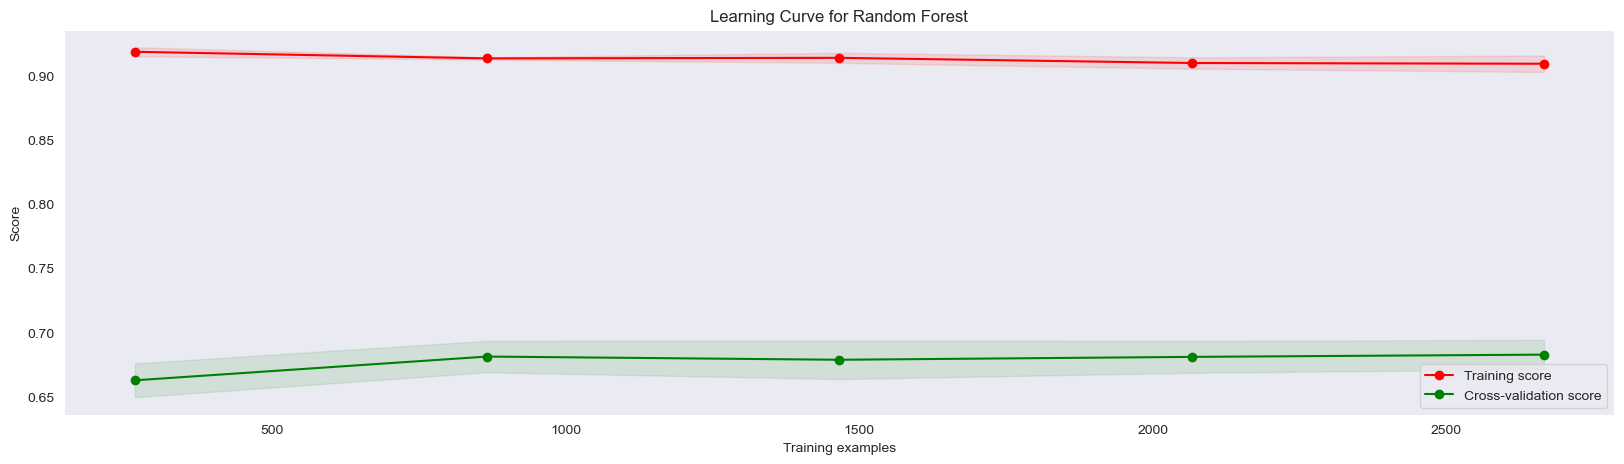

In [83]:
print(type(y_train))
rf = RandomForest()  # Assuming this is an instance of your RandomForest class with a defined model
plot_training_curve(random_forest._model, "Learning Curve for Random Forest", x_train, y_train, cv=3)
plt.show()
